# TODO

* number sections
* acknowledgement of reqs

# Book Genres vs. Emotions with PySpark and Sentence Transformers

### Nicholas (Kiko) Whiteley

### ICS 438 Final Project - Fall 2022

## Abstract

A book's description often serves as a "hook" to entice the reader.  These descriptions are well-crafted and concise but can nonetheless can be several sentences long.

This project leverages PySpark's parallelism to analyze over 1 million books, charting the relationship between their provided descriptions and tagged genres.

## How To Run This Project

This project is intended to be run in the PySpark Docker environment from Assignment 1.

It uses the default Python 3 ipykernel, so the included installs should be sufficient.

Run the following command from the project directory:

```
docker run --rm -p 4040:4040 -p 8888:8888 -v $(pwd):/home/jovyan/work jupyter/all-spark-notebook
```

In [149]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)

from IPython.display import clear_output
!pip install sentence-transformers
!pip install pyspark
!pip install nltk
import nltk
nltk.download('punkt')
clear_output()

from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelWithLMHead

## Dataset Setup

Dataset was downloaded [from Kaggle](https://www.kaggle.com/datasets/sp1thas/book-depository-dataset)

After download, the file `datasets.csv.zip` was unzipped and renamed `books_raw.csv`.

### Data Directory

Edit `DATA_DIR` if needed.

In [2]:
DATA_DIR = f'{os.getcwd()}/data'
assert os.path.isdir(DATA_DIR)

### Data Paths

In [3]:
FILE_NAMES = ['books_raw', 'categories', 'features']

def csv_or_zip(file_name):
    path = f'{DATA_DIR}/{file_name}.csv'
    if os.path.exists(path):
        return path
    elif os.path.exists(f'{path}.zip'):
        return f'{path}.zip'
    else:
        print(f'No path found for `{file_name}`.')
        return None

PATHS = {
    name: csv_or_zip(name) for name in FILE_NAMES
}

## Dataset Overview

The main file (`books_raw.csv`) contains over 1 million rows (one for each book) with 28 features.  Encoded feature values are included in the other `.csv` files.

### Features of Interest

In [4]:
display_left_align = lambda df: display(
    df.style.set_table_styles([
        dict(
            selector = 'th',
            props = [('text-align', 'left')]
        ),
        dict(
            selector = 'td',
            props = [('text-align', 'left')]
        )
    ])
)

display_left_align(pd.read_csv(PATHS['features']))

,Feature,Column Name,Data Type,Details
0,Description,`description`,String,Premise / preview / details.
1,Categories,`categories`,List of integers,Genre tags. Integers map to strings in `categories.csv`.


In [5]:
from pyspark import SparkContext

# Start Spark Context if not started.
try:
    sc = SparkContext()
except:
    pass

In [6]:
# rdd.take(1)

In [7]:
import multiprocessing

multiprocessing.cpu_count()



5

In [8]:
sc.getConf()

In [9]:

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StringType, IntegerType 
from pyspark.sql.types import ArrayType, DoubleType, BooleanType



session = SparkSession(sc)
# session = SparkSession.builder.appName('temp').getOrCreate()
# session = SparkSession.builder.appName('temp').config(
#     "spark.driver.extraJavaOptions",
#     "--add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED",
# ).getOrCreate()


> NOTE: The `categories` column from `books_raw.csv` was not compatible to be read as an `Array<int>` data type with a custom PySpark schema.  It is read as a string and handled later.

In [10]:
import pyspark.sql.utils

try:
    schema = StructType() \
        .add('categories', ArrayType(IntegerType()), True) \
        .add('description', StringType(), True)
    books = session.read \
        .options(header='true') \
        .schema(schema) \
        .csv(PATHS['books_raw']
    )
except pyspark.sql.utils.AnalysisException as e:
    print(e, '\n')
    print('Proceeding with string datatype for `categories` column.')
    books = session.read \
    .options(header='true', inferSchema=True) \
    .csv(PATHS['books_raw'])

CSV data source does not support array<int> data type. 

Proceeding with string datatype for `categories` column.


In [11]:
# Only keep features of interest; rename columns to shorter names.
books = books.selectExpr(
    'description as desc',
    'categories as cat_ids_raw'
)
books = books.repartition(1000)

### Total number of books

In [12]:
'%d (%.3f million) total books.' % (
    books.count(),
    books.count()/1e6
)

'1110594 (1.111 million) total books.'

## Category Names & IDs

In [13]:
categories = session.read \
    .options(header='true', inferschema='true') \
    .csv(PATHS['categories']
)
categories = categories.selectExpr(
    'category_id as id_raw',
    'category_name as name'
)

In [14]:
e = 0
for i in tqdm(categories.toLocalIterator(), total=2775):
    if e < 4000:
        if type(i.id_raw) != int:
            print(type(i.id_raw))
        e+=1
    else:
        break

100%|██████████| 2775/2775 [00:00<00:00, 44384.93it/s]


In [15]:
# categories.select(categories.id_raw, F.array_position(categories.id_raw, 0)).show()

### Number of unique

In [16]:
from pyspark.sql import functions as F
categories.agg(
    F.countDistinct(F.col('id_raw')),
    F.countDistinct(F.col('name'))
).show()

+-------------+-----------+
|count(id_raw)|count(name)|
+-------------+-----------+
|         2775|       2585|
+-------------+-----------+



Since there are more unique IDs than names, `190 = 2775-2585` IDs map to duplicate names.

Furthermore, not all IDs are used, as shown below:

In [17]:
categories.agg(
    F.min(F.col('id_raw')),
    F.max(F.col('id_raw'))
).show()

+-----------+-----------+
|min(id_raw)|max(id_raw)|
+-----------+-----------+
|          2|       3390|
+-----------+-----------+



`615 = 3390-2275` category IDs are not used.

Thus, IDs should be reindexed so that all IDs are used and duplicates map to the same ID.

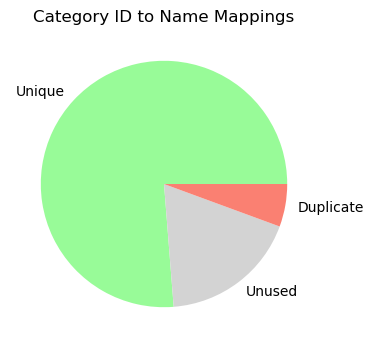

In [18]:
# import matplotlib.colors as mcolors

CAT_ID_COMP = dict(
    Unique    = 2585,
    Unused    = 615,
    Duplicate = 190
)
assert np.sum(list(CAT_ID_COMP.values()))==3390

fig = plt.figure(figsize=(4,4))
plt.title('Category ID to Name Mappings')
_ = plt.pie(
    CAT_ID_COMP.values(),
    labels = CAT_ID_COMP.keys(),
    colors=['palegreen', 'lightgray', 'salmon']
)


## Reindexing Category IDs

Since `categories.csv` has less than 3000 rows, load it into RAM for now.

In [19]:
cats_df = categories.toPandas()
cats_df.dtypes

id_raw     int32
name      object
dtype: object

IDs will be reassigned to their alphabetical position in the list, duplicates removed.

In [20]:
cat_names = list(cats_df.name.unique())
cat_names.sort()

In [21]:
def cat_id_to_name(cat_id, raw=True):
    id_col = 'id_raw' if raw else 'id_clean'
    return cats_df.loc[cats_df[id_col]==cat_id].name.values[0]

def cat_id_raw_to_clean(id_raw):
    name = cat_id_to_name(id_raw)
    return cat_names.index(name)



cats_df['id_clean'] = cats_df.id_raw.apply(cat_id_raw_to_clean)
assert np.amax(cats_df.id_clean)==(CAT_ID_COMP['Unique']-1)
cats_df

,id_raw,name,id_clean
0,1998,.Net Programming,0
1,176,20th Century & Contemporary Classical Music,1
2,3291,20th Century & Contemporary Classical Music,1
3,2659,20th Century History: C 1900 To C 2000,2
4,2661,21st Century History: From C 2000 -,3
...,...,...,...
2770,1634,Zoology: Invertebrates,2580
2771,1644,Zoology: Mammals,2581
2772,1639,Zoology: Vertebrates,2582
2773,3007,Zoos & Wildlife Parks,2583


In [22]:
PATHS['categories']

'/home/jovyan/work/data/categories.csv'

In [23]:
def str_to_int_list(s):
    s = str(s)
    # Replace brackets and commas with spaces, then tokenize.
    s = re.sub(r'[\[\]\,]', ' ', s).split()
    # Convert to int if possible.
    def int_or_nan(e):
        try:
            # Ensure no decimals.
            assert int(e)==float(e)
            return int(e)
        except:
            # Category ID 0 will denote missing value.
            print(f'Invalid number: {e}')
            return np.nan
    return [int_or_nan(e) for e in s]

str_to_int_list('[-1,  3.3,4, A]')

Invalid number: 3.3
Invalid number: A


[-1, nan, 4, nan]

In [24]:
cat_id_raw_to_clean = lambda id_raw: \
    cats_df.loc[cats_df.id_raw==id_raw].id_clean.values[0]

# Test case
assert cat_id_raw_to_clean(1634)==2580

In [25]:
def reindex_cat_ids(ids_raw_str):
    try:
        ids_raw   = str_to_int_list(ids_raw_str)
        ids_clean = [cat_id_raw_to_clean(e) for e in ids_raw]
        ids_clean = list(set(ids_clean))
        ids_clean.sort()
        return str(ids_clean)
    except:
        return str([])

reindex_cat_ids('[1998, 176]')

'[0, 1]'

Use a PySpark User-Defined Function (`udf`) to reindex categories.

In [26]:
from pyspark.sql.functions import udf
udf_reindex_cat_ids = udf(reindex_cat_ids, StringType())


books = books.withColumn(
    'cat_ids_clean', udf_reindex_cat_ids('cat_ids_raw')
)

In [27]:
cat_ids_first_row = books.select('cat_ids_raw', 'cat_ids_clean').take(1)[0]
print(f'Cat IDs, Raw:   {cat_ids_first_row[0]}')
print(f'Cat IDs, Clean: {cat_ids_first_row[1]}')

Cat IDs, Raw:   [364, 2633, 368, 2637]
Cat IDs, Clean: [1053, 1058]


In [28]:
cat_ids_first_row[0]

'[364, 2633, 368, 2637]'

In [29]:
books.schema

StructType([StructField('desc', StringType(), True), StructField('cat_ids_raw', StringType(), True), StructField('cat_ids_clean', StringType(), True)])

### Number of books applying to each category

Note: a book may have several categories.

In [30]:


cat_counts =[0] * CAT_ID_COMP['Unique']

def tally_cats(cats_str):
    try:
        cats_ints = str_to_int_list(cats_str)
        for i in cats_ints:
            # print('i', i)
            cat_counts[i] += 1
    except:
        pass



In [31]:
itr = tqdm(books.select('cat_ids_clean').toLocalIterator(), total=1110594)
# itr = tqdm(books.toLocalIterator(), total=1110594)

  0%|          | 0/1110594 [00:00<?, ?it/s]

In [32]:
for i in itr:
    tally_cats(str(i[0]))

100%|██████████| 1110594/1110594 [10:04<00:00, 1835.88it/s]


In [33]:
# cat_counts = pd.Series(cat_counts)
# cat_counts.to_csv('temp.csv')

## Category Clustering

Each description may 

Code references [this HuggingFace article](https://huggingface.co/mrm8488/t5-base-finetuned-emotion).

In [150]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")
from nltk.tokenize import sent_tokenize
clear_output()

In [50]:
[tokenizer.decode(i) for i in range(6)]

['<pad>', '</s>', '<unk>', '', 'X', '.']

In [62]:
em_words = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
em_word_to_id = pd.DataFrame.from_dict(
    {w: i for i, w in enumerate(em_words)},
    orient  = 'index',
    columns = ['em_id']
)

In [63]:
em_word_to_id

,em_id
sadness,0
joy,1
love,2
anger,3
fear,4
surprise,5


In [75]:
# Outputs an ID
def predict_em_id(text):
    input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

    output = model.generate(input_ids=input_ids,
                   max_length=2)
    dec = [tokenizer.decode(ids) for ids in output]
    label = dec[0][6:]
    return em_word_to_id.loc[label].values[0]

In [45]:
x = books.first()['desc']

In [77]:
[predict_em_id(s) for s in x.split('. ')]

[4, 1]

In [114]:
type(predict_em_id('hey'))

numpy.int64

### Top categories

The category name file has less than 3000 rows, so we will temporarily fit it into RAM to inspect the most common categories

In [ ]:
cats_top_10 = cat_counts.sort_values(ascending=False).head(10)

### Category-Emotion Co-occurrences

These will be stored (encoded as integers) in a NumPy array.

One row for each category ID; one column for each emotion ID.

In [123]:
cat_em_cos = np.zeros(
    shape=(CAT_ID_COMP['Unique'], 6)
)

In [80]:
cat_em_cos.shape

(2585, 6)

In [200]:
del itr2

In [201]:
itr2 = tqdm(books.toLocalIterator(), total=1110594)

  0%|          | 0/1110594 [00:00<?, ?it/s]

In [216]:
t = 0
def tally_cat_em_cos(row):
    desc = row['desc']
    print(desc)
    try:
        cat_ids = str_to_int_list(row['cat_ids_clean'])
        print(cat_ids)
        if len(cat_ids) > 0:
            # Loop through sentences.
            for s in sent_tokenize(desc):
            # print(sens)
                # print('cl', len(cat_ids))
                ei = predict_em_id(s)
                print(sen_em_ids)
                for sei in sen_em_ids:
                    print('s', sei)
                    for c in cat_ids:
                        print('s,c', sei, c)
        # print(type(em_ids))
                        cat_em_cos[c, sei] += 1
    except:
        pass

In [217]:
e = 0
for row in itr2:
    if e < 1:
        tally_cat_em_cos(row)
        e += 1
    else:
        break

Imagine you are fluent in a magical language of prophecy, a language so powerful it can accurately describe things you cannot see or even imagine. Einstein's Heroes takes you on a journey of discovery about just such a miraculous language-the language of mathematics-one of humanity's most amazing accomplishments.
[259, 264, 1127, 1131, 1441, 1863]
1


In [213]:
t

0

In [206]:
np.sum(cat_em_cos)

111.0

In [154]:
xy = sent_tokenize('Explores the sources in real life of all the Tintin adventures. Many people dismiss the world of the paranormal as impossible. Others, based on their own unsatisfactory experiences, conclude that all claims of profound intuitiveness amount to fakery. Fictionalized images of sorcerers and soothsayers consorting with unholy forces linger among us, while media exposés of pseudo-psychics leave little room for the voices of genuinely gifted extrasensory consultants to be heard and fairly judged')

In [155]:
type(xy)

list

In [162]:
xx = np.array([[0,0,0],[1,1,1]])

In [163]:
xx[[0,1], [1,2]]+= 10

In [164]:
xx

array([[ 0, 10,  0],
       [ 1,  1, 11]])

In [ ]:


cats_top_10 = pd.DataFrame.from_dict(dict(
    name  = [
        cat_id_to_name(cat_id) for cat_id in cats_top_10.index
    ],
    count    = cats_top_10,
    fraction = cats_top_10 / books.count()
    
))
cats_top_10

## Data Cleaning



In [ ]:
iter = tqdm(
    pd.read_csv(PATHS['books_raw'], chunksize=25),
    total = NCHUNKS['books_raw']
)
for chunk in iter:
    pass

## Data Overviews

In [ ]:
get_emotion("i feel as if i havent blogged in ages are at least truly blogged i am doing an update cute") # Output: 'joy'

In [ ]:
get_emotion("i have a feeling i kinda lost my best friend") # Output: 'sadness'

In [ ]:
get_emotion(df.at[0, 'desc'])